### Enviroment Set~Up

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version

import tensorflow as tf 

assert version.parse(tf.__version__) >=version.parse("2.8.0")

2025-07-21 09:09:06.264189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753088946.427681      60 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753088946.476415      60 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')


In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
import numpy as np

### Introduction to -openAl Gym ~ Gymnasium

In [6]:
import gymnasium as gym
env = gym.make("CartPole-v1",render_mode="rgb_array")

In [7]:
"""Show all the available enviroments in gymnasium"""
envs = gym.envs.registry

sorted(envs.keys())[:10]+["..."]

['Acrobot-v1',
 'Ant-v2',
 'Ant-v3',
 'Ant-v4',
 'BipedalWalker-v3',
 'BipedalWalkerHardcore-v3',
 'Blackjack-v1',
 'CarRacing-v2',
 'CartPole-v0',
 'CartPole-v1',
 '...']

In [8]:
"""show the specification for the `CartPole-v1` environment"""
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

*lets initialize the enviroment by calling is `reset()` method. this return an observation ,as well as a dictonary that may contain extra information . Both are enviroment-specific*

In [9]:
obs,info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [10]:
info

{}

In [11]:
img = env.render()
img.shape

error: XDG_RUNTIME_DIR not set in the environment.


(400, 600, 3)

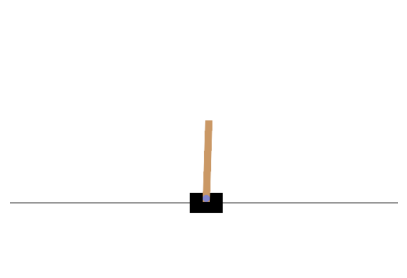

In [12]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

*lets see how to interect with an enviroment. your agent will need to select an action from an "action space" (the set of possible actions).Lets see what this enviroment'a action space looks like*

In [13]:
env.action_space

Discrete(2)

In [14]:
action =1 
obs, reward, done, truncated, info = env.step(action)
print(obs) # new observation 
print(reward) # get reward for the action ,no matter what the action is
print(done) # this value will be true if the episode is over , it become true on last step or before the enviroment reset again 
print(truncated) # true when the episode is interrupted early due to the enviroment 
print(info)



[ 0.02727336  0.18847767  0.03625453 -0.26141977]
1.0
False
False
{}


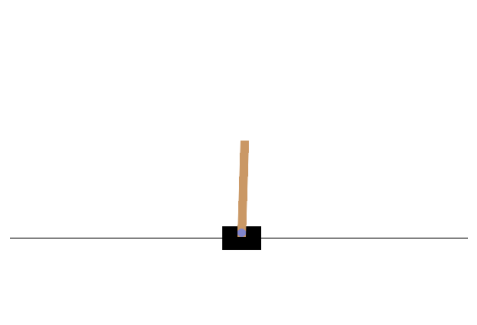

In [15]:
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

In [16]:
"""when the episode is over , we need to reset the environment or truncate=True , we need to reset the environment"""
if done or truncated:
    obs,info = env.reset()

### A simple hard-coded policy

*hardcode a simple policy that accelerates left when the pole is learning toward the left and accelerates right when the pole is learning the right*

In [17]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle <0 else 1

totals = []

for episode in range(500):
    episode_rewards=0
    obs, info = env.reset(seed = episode)
    
    for step in range(200):
        action = basic_policy(obs)
        obs,reward,done,truncated,info = env.step(action)
        episode_rewards +=reward
        if done or truncated:
            break
    
    totals.append(episode_rewards)

In [18]:
np.mean(totals),np.std(totals),np.min(totals),np.max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [19]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)


### Neural Network Policies

In [20]:
import tensorflow as tf
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid"),
])

In [21]:
"""A function that creates an animation for a given policy """

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis],verbose=0)[0][0]
    return int(np.random.rand()>left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

error: XDG_RUNTIME_DIR not set in the environment.
I0000 00:00:1753088995.410736      60 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1753088995.792767      98 service.cc:148] XLA service 0x7fcbc0015ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753088995.793303      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753088995.962244      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753088996.279824      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in

### Policy Gradients

In [22]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [23]:
def play_multiple_episodes(env,n_episodes,n_max_steps,model,loss_fn):
    all_rewards=[]
    all_grads=[]
    for episodes in range(n_episodes):
        current_rewards =[]
        current_grads = []
        obs,info= env.reset()
        for step in range(n_max_steps):
            obs,reward,done,truncated,grads = play_one_step(env,obs,model,loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
        
    return all_rewards,all_grads

In [24]:
def discount_rewards(rewards,discount_factor):
    discounted=np.array(rewards)
    for step in range(len(rewards)-2,-1,-1):
        discounted[step]+=discounted[step+1]*discount_factor
    return discounted


def discount_and_normalize_rewards(all_rewards,discount_factor):
    all_discounted_rewards=[discount_rewards(rewards,discount_factor)
                            for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean  = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards-reward_mean)/reward_std
            for discounted_rewards in all_discounted_rewards]

In [25]:
discount_rewards([10,0,-50],discount_factor=0.7)

array([-14, -35, -50])

In [26]:
discount_and_normalize_rewards([[10,0,-50],[10,20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [27]:
n_iterations = 150 
n_episodes_per_update  = 10
n_max_steps = 200
discount_factor=0.95


In [28]:

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid"),
])

obs,info = env.reset(seed=42)

In [29]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [66]:
for iteration in range(n_iterations):
    all_rewards ,all_grads = play_multiple_episodes(
        env,n_episodes_per_update,n_max_steps,model,loss_fn)
    
    total_rewards = sum(map(sum,all_rewards))
    
    print(f"\rIteration:{iteration+1}/{n_iterations},"
          f"mean rewards:{total_rewards/n_episodes_per_update:.1f}",end="")
    
    all_final_rewards = discount_and_normalize_rewards(all_rewards,discount_factor)
    
    all_mean_grads=[]
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward*all_grads[episode_index][step][var_index]
             for episode_index,final_reward in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_reward)],axis=0)
        all_mean_grads.append(mean_grads)
    
    optimizer.apply_gradients(zip(all_mean_grads,model.trainable_variables))

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:312: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())


Iteration:2/150,mean rewards:28.2

KeyboardInterrupt: 

In [30]:
np.random.seed(42)
show_one_episode(pg_policy)

error: XDG_RUNTIME_DIR not set in the environment.
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


### Markov chains

In [6]:
np.random.seed(42)

transition_probabilities =[
    [0.7,0.2,0.0,0.1],
    [0.0,0.0,0.9,0.1],
    [0.0,1.0,0.0,0.0],
    [0.0,0.0,0.0,1.0]
]

n_max_steps=1000
terminal_states =[3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state,end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...",end="")
    print()
    
for idx in range(10):
    print(f"Run #{idx+1}: ",end="")
    run_chain(start_state=0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


### Markov Decision Process

In [9]:
transition_probabilities=[
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0,1,2],[0,2],[1]]

### Q~value Iteration 

In [10]:
Q_values = np.full((3,3),-np.inf)
for state,actions in enumerate(possible_actions):
    Q_values[state,actions]=0.0

In [11]:
gamma = 0.90

history1=[]

for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s,a]=np.sum([
                    transition_probabilities[s][a][sp]
                    *(rewards[s][a][sp]+gamma*Q_prev[sp].max())
                for sp in range(3)
            ])
            
history1=np.array(history1)

In [12]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [13]:
Q_values.argmax(axis=1)

array([0, 0, 1])

### Q~Learning

In [14]:
def step(state,action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2],p=probas)
    reward = rewards[state][action][next_state]
    return next_state,reward

In [15]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [16]:
np.random.seed(42)

Q_values = np.full((3,3),-np.inf)
for state,actions in enumerate(possible_actions):
    Q_values[state][actions]=0

In [17]:
alpha0= 0.05 # initial learning rate
decay = 0.005 # learning rate decay 

gamma =0.90 # discount factor

state = 0 # initial state

history2 =[]

for iteration in range(10_000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state ,reward = step(state,action)
    next_value = Q_values[next_state].max()
    alpha = alpha0/(1+iteration*decay)
    Q_values[state,action]*=1-alpha
    Q_values[state,action]+=alpha*(reward+gamma*next_value)
    state=next_state

history2 = np.array(history2)

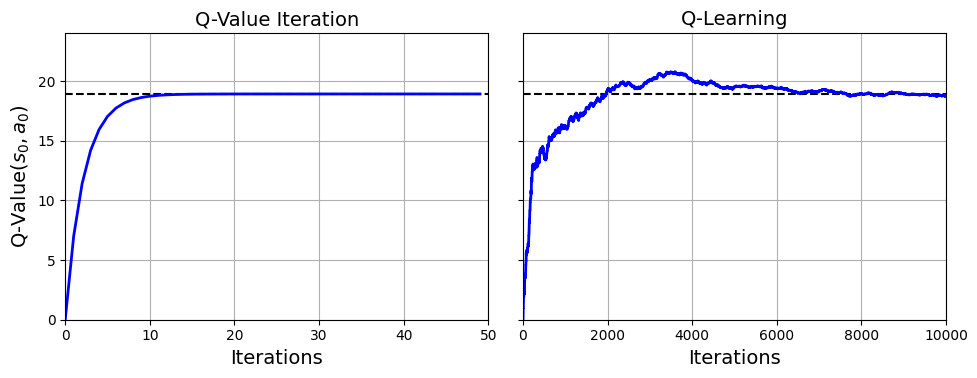

In [18]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

### Deep Q-Network 

In [32]:
tf.random.set_seed(42)

input_shape = [4]

n_outputs = 2 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation="elu",input_shape = input_shape),
    tf.keras.layers.Dense(32,activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
def epsilon_greedy_policy(state,epsilon=0):
    if np.random.rand()<epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis],verbose=0)[0]
        return Q_values.argmax()

In [34]:
from collections import deque
replay_buffer  = deque(maxlen=2000)

In [35]:
class ReplayBuffer:
    def __init__(self,max_size):
        self.buffer  =np.empty(max_size,dtype=object)
        self.max_size  = max_size
        self.index = 0
        self.size= 0
        
    def append(self,obj):
        self.buffer[self.index]=obj
        self.size = min(self.size+1,self.max_size)
        self.index = (self.index+1)%self.max_size
        
    def sample(self,batch_size):
        indices = np.random.randint(self.size , size =batch_size)
        return self.buffer[indices]

In [36]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer),size= batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

In [37]:
def play_one_step(env,state,epsilon):
    action = epsilon_greedy_policy(state,epsilon)
    next_state , reward,done,truncated,info = env.step(action)
    replay_buffer.append((state,action,reward,next_state,done,truncated))
    return next_state,reward,done,truncated,info

In [38]:
env.reset(seed = 42) 
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0



In [39]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [43]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
        
        
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights) 

Episode: 600, Steps: 200, eps: 0.010

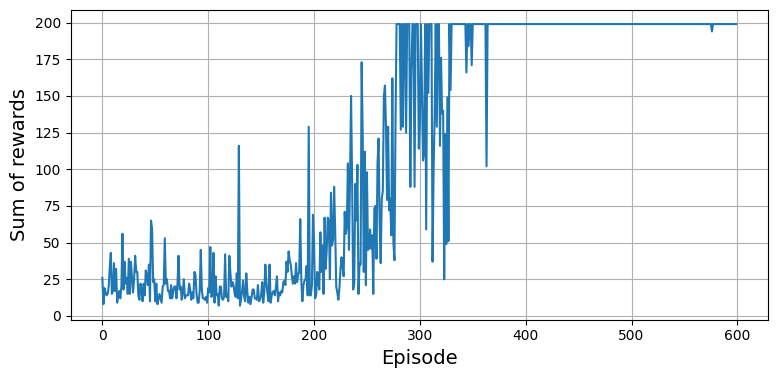

In [44]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

### Fixed Q~value Targets

In [40]:
tf.random.set_seed(42)

model= tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation="relu",input_shape = input_shape),
    tf.keras.layers.Dense(32,activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [41]:
target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())



In [52]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards=[]
best_score=0

batch_size=32
discount_factor=0.95
optimizer= tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

replay_buffer = deque(maxlen=2000)

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states,actions,rewards,next_states,dones,truncateds = experiences
    next_Q_values = target.predict(next_states,verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs =1.0 - (dones | truncateds)
    target_Q_values = rewards+runs*discount_factor*max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions,n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values*mask,axis=1,keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values,Q_values))
    
    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

In [53]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:                        # <= CHANGED
            target.set_weights(model.get_weights())  # <= CHANGED

    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #training_step(batch_size)
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index, online_weight in enumerate(online_weights):
        #    target_weights[index] = (0.99 * target_weights[index]
        #                             + 0.01 * online_weight)
        #target.set_weights(target_weights)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 600, Steps: 200, eps: 0.010

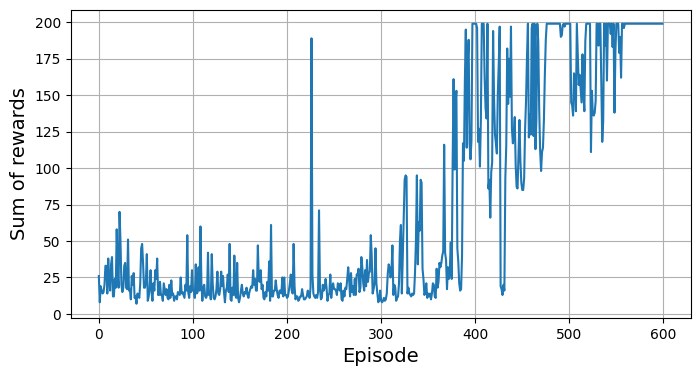

In [54]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [55]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

error: XDG_RUNTIME_DIR not set in the environment.


### Double DQN 

In [58]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation = "elu",input_shape = input_shape),
    tf.keras.layers.Dense(32,activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])
target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    """ CHANGED SECTION """
    next_Q_values = model.predict(next_states,verbose=0)
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask= tf.one_hot(best_next_actions,n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states,verbose=0)*next_mask).sum(axis=1)
    """ END OF CHANGED SECTION """
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 600, Steps: 15, eps: 0.0100

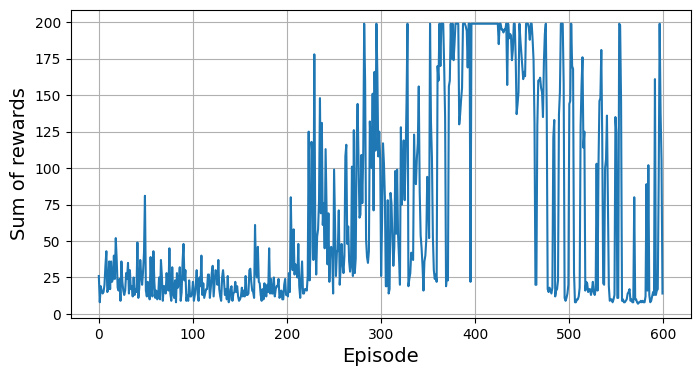

In [59]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [60]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

error: XDG_RUNTIME_DIR not set in the environment.


### Dueling Double DQN 

In [63]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# extra code – trains the model

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)
